### **GD - Ejercicio 2**

### El trabajo tiene como objetivo la realización de 2 análisis concretos, pasando por las fases previas de verificación, comprobación y depuración de los datos.
### En particular se deben considerar los aspectos vistos en clase sobre la calidad de los datos, así como las transformaciones más comunes antes de un análisis (entre otras el tratamiento de valores perdidos, normalización de los datos cuando sea necesario y limpieza de outliers).

### Tan importante como realizar e informar correctamente sobre los 2 análisis solicitados, será la realización y documentación de los pasos previos,justificando las decisiones tomadas: si se normalizan los valores de los atributos o no, qué se considera valor perdido, qué se hace con ellos, etc. Es decir que, entre otras cosas, el informe debe incluir también estadísticas de valores perdidos y outliers encontrados en los datos, así como estadísticas globales antes y después de cada transformación.

### Los 2 análisis que deben hacerse son:

### • Para cada año de los que haya información, lista de géneros con la media de puntuación para cada uno, ordenados de mayor a menos según esta media.

### • Para cada uno de los géneros encontrados, evolución de las puntuaciones medias anuales a lo largo de los años

In [ ]:
import pandas as pd
import numpy as np
import time
from itertools import chain

### **Carga de datos y visualización de datos**

In [ ]:
movies = pd.read_csv("movies.csv")
rating = pd.read_csv("ratings.csv")

In [ ]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.shape

(62423, 3)

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
type(movies["title"][0])

str

In [ ]:
type(movies["genres"][0])

str

Se observa que el dataframe de películas esta formado por tres columnas:
- movieId: Identificador de las películas. Tiene un valor numérico (int64)
- title: El título de la película con su año de salida entre paréntesis. Se trata de un string.
- genres: Los géneros de la película, que si una película tiene más de un género van juntos y separados por el símbolo |. Se trata de un string. Habra que separar los géneros en diferentes columnas (one_hot) para las consultas finales.

Esta compuesto por 62423 películas

In [ ]:
rating.head(5)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
rating.shape

(727573, 4)

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727573 entries, 0 to 727572
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     727573 non-null  int64  
 1   movieId    727573 non-null  int64  
 2   rating     713254 non-null  float64
 3   timestamp  727573 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 22.2 MB


Se observa que el dataframe de valoraciones esta formado por cuatro columnas:
- userId: Identificador del usuario. Valor numérico (int64).
- movieId: Identificador de la película (se podrá unir las dos tablas a partir de este valor). Valor numérico (int64).
- rating: Valoración dada (de 0 a 5 estrellas y se van añadiendo de 0.5 a 0.5). Valor numérico (float64).
- timestamp: Los segundos que han pasado desde medianoche del 1 de enero de 1970 a la publicación de la valoración. Valor numérico (int64).
Para nuestra consulta final necesitaremos obtener los años de este dato, por lo que habra que transformarlo.

Tiene 25000095 valoraciones.

# MOVIES

### **Datos duplicados**

Se comprobará si hay datos duplicados (todas las columnas iguales) en las dos tablas y se eleminaran.

In [ ]:
len(movies[movies.duplicated()])

0

In [ ]:
len(movies[movies.duplicated(subset=["movieId"])])

0

In [ ]:
len(movies[movies.duplicated(subset=["title"])])

98

In [ ]:
movies[movies.duplicated(subset=["title"],keep=False)].sort_values('title',ascending=False)

,movieId,title,genres
17391,91199,Weekend (2011),Drama|Romance
50600,181385,Weekend (2011),Comedy|Drama|Romance
12909,64997,War of the Worlds (2005),Action|Sci-Fi
10055,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
49653,179333,Veronica (2017),Horror
...,...,...,...
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
37060,151797,Absolution (2015),Drama|Thriller
30628,136696,Absolution (2015),Action|Adventure|Crime|Thriller
61103,204982,9 (2009),Comedy


Se observa que hay varias películas con el mismo título, el cual debería de ser único pero con distinto movieId y géneros. Para procesar esto habrá primero que transformar la columna "genres", en columnas que nos facilite su análisis y limpieza.

### **Transformación de la columna genres de movies**

Se guarda la lista de géneros podría es importante para más adelante

In [ ]:
listaGenres=movies["genres"].str.split("|", expand=True).stack().unique()
listaGenres=listaGenres.tolist()
listaGenres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Science fiction',
 'IMAX',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Film-Noir',
 'Sci-Fi',
 '(no genres listed)']

Para ellos hemos realizado lo siguiente:
- Se ha generado un df en el se genera una fila extra por género como se puede observar en el movieAux
- Luego se ha realizado un get_dummies separar los valores de la columna "genres" en diferentes columnas y así poder analizar de una forma más sencilla que una película pertenece a un género o a varios.
- Por último se agrupan y se suman esas filas generadas y se une con la tabla movies. También se borra la columna "genres" ya que lo hemos sustituidos por las nuevas columnas.

In [ ]:
moviesAux=movies.assign(genres=movies['genres'].str.split('|')).explode('genres')

In [ ]:
moviesAux.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children


In [ ]:
genres=pd.get_dummies(moviesAux["genres"])
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Science fiction,Thriller,War,Western
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62420,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
62421,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62422,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62422,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
genres=genres.groupby(genres.index).sum()
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Science fiction,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
62419,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
62420,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
62421,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movies=movies.join(genres)

In [ ]:
movies=movies.drop(["genres"],axis=1)

In [ ]:
movies.head(3)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Science fiction,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


### **Valores perdidos**

In [ ]:
movies.isnull().sum()

movieId               0
title                 0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Science fiction       0
Thriller              0
War                   0
Western               0
dtype: int64

Tras esta consulta solo podemos asegurar que todas las películas tienen moviesId, ya que los demás son del tipo String y  podría estar identificado con un valor diferente. Una cosa que observamos del procesamiento de la columna genres del apartado anterior, es que hay un género llamado "no genres listed" el cual se considera como un valor que no se necesita. Por lo que las filas que contengan este género se eliminaran.

In [ ]:
movies=movies.loc[movies["(no genres listed)"]==0]

In [ ]:
len(movies[movies["(no genres listed)"]==1])

0

Y se elimina la columna "no genres listed"

In [ ]:
movies=movies.drop(["(no genres listed)"],axis=1)

In [ ]:
listaGenres=listaGenres[:-1]

### **Duplicados de películas**

Ahora se tratara las filas que tienen mismo título con diferentes movieId y géneros.

En el siguiente bloque se muestra los títulos de películas repetidos, y nos da que hay 98 películas repetidas.

In [ ]:
moviesRep=movies[movies.duplicated(subset=["title"],keep=False)].sort_values('title',ascending=False)
moviesRep2=moviesRep
moviesRep

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Science fiction,Thriller,War,Western
50600,181385,Weekend (2011),0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
17391,91199,Weekend (2011),0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
10055,34048,War of the Worlds (2005),1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
12909,64997,War of the Worlds (2005),1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49443,178895,Veronica (2017),0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,588,Aladdin (1992),0,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
37060,151797,Absolution (2015),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
30628,136696,Absolution (2015),1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
61103,204982,9 (2009),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La forma de resolver este problema, el cual se ha pensado, es juntar los géneros de las repeticiones haciendo que uno tiene el género "Aventura" y el otro no, el resultado será una única película con el género de "Aventura". Para ello, hemos hecho lo siguiente: se ha obtenido las segundas repeticiones de las películas, se ha sumado los géneros de los repetidos y los valores mayores que 2 pasarlos a 1 y eliminar las filas repetidas y sustituir las columnas de género por el resultado.

In [ ]:
moviesRepL=movies[movies.duplicated(subset=["title"],keep="last")]

In [ ]:
moviesRepId = moviesRepL["movieId"]
moviesRepId

580         588
1710       1788
2553       2644
2759       2851
3454       3553
          ...  
55534    192157
57843    197281
58728    199219
59537    201074
60497    203449
Name: movieId, Length: 83, dtype: int64

In [ ]:
moviesRepId=moviesRepId.tolist()

In [ ]:
moviesRep=moviesRep.groupby("title")[listaGenres].sum()

In [ ]:
moviesRep[moviesRep2==2]=1

In [ ]:
movies=movies.drop_duplicates(subset=["title"],keep="first")

In [ ]:
pd.options.mode.chained_assignment = None
movies[movies["title"].isin(moviesRep.index)][listaGenres]=moviesRep[listaGenres]
pd.options.mode.chained_assignment = "raise"

Ahora se haran comprobaciones para ver si hemos procesado los datos correctamente

In [ ]:
len(movies[movies.duplicated(subset=["title"])])

0

In [ ]:
movies.isnull().sum()

movieId            0
title              0
Action             0
Adventure          0
Animation          0
Children           0
Comedy             0
Crime              0
Documentary        0
Drama              0
Fantasy            0
Film-Noir          0
Horror             0
IMAX               0
Musical            0
Mystery            0
Romance            0
Sci-Fi             0
Science fiction    0
Thriller           0
War                0
Western            0
dtype: int64

Se comprueba que si hay películas sin un género marcado.

In [ ]:
dem=movies[movies[listaGenres]==0].all(axis=1)
dem[dem==True]

Series([], dtype: bool)

In [ ]:
movies.reset_index(drop=True,inplace=True)

Con todos estos bloques damos por terminado el procesamiento de la tabla de películas.

# Rating

### **Datos duplicados**

In [ ]:
len(rating[rating.duplicated()])

21

In [ ]:
rating=rating.drop_duplicates()

En la tabla de rating se detecta 671 filas duplicadas por lo que se eliminan.

In [ ]:
rating.sort_values('timestamp',ascending=True)

,userId,movieId,rating,timestamp
727572,4956,2580,4.5,115587780
326810,2262,1079,3.0,789652009
326767,2262,47,5.0,789652009
326761,2262,21,3.0,789652009
534341,3672,5,2.0,825009968
...,...,...,...,...
79320,606,203244,5.0,1574253743
79046,606,97306,5.0,1574253749
78721,606,0,5.0,1574253766
660896,4518,4226,4.5,1574262765


In [ ]:
prueba2=rating.sort_values('timestamp',ascending=True).drop_duplicates(subset=["userId", "movieId"], keep='last')

In [ ]:
prueba2[(prueba2["userId"] == 2) & (prueba2["movieId"] == 0)]

,userId,movieId,rating,timestamp
170,2,0,4.5,1141417214


In [ ]:
ordenado=rating.sort_values('timestamp',ascending=True)

In [ ]:
prueba=ordenado[ordenado.duplicated(subset=["userId","movieId"])]

In [ ]:
prueba=rating.sort_values('timestamp',ascending=True)[rating.sort_values('timestamp',ascending=True).duplicated(subset=["userId","movieId"])]

In [ ]:
prueba[prueba["userId"]==3]

,userId,movieId,rating,timestamp
618,3,0,4.0,1439474122
378,3,0,3.5,1439474211
255,3,0,4.5,1484754967
848,3,0,4.0,1484755521
428,3,0,3.5,1566089728


In [ ]:
prueba=rating[rating.duplicated(subset=["userId","movieId"],keep="last")]

In [ ]:
prueba

,userId,movieId,rating,timestamp
159,2,0,4.5,1141416992
170,2,0,4.5,1141417214
255,3,0,4.5,1484754967
378,3,0,3.5,1439474211
428,3,0,3.5,1566089728
...,...,...,...,...
726831,4952,0,3.5,1168839602
726893,4952,0,4.5,1153863924
726970,4952,0,3.0,1152683930
727229,4953,0,4.5,1406314476


In [ ]:
len(rating[rating.duplicated(subset=["userId","movieId"],keep=False)])

6099

Se encuentra que 206912 valoraciones, son del mismo usuario a la misma película pero en diferentes momentos. Lo cual ha sido preguntado al profesor Ortigosa y no es un error que se haya contemplado y que podría ocurrir. La decisión que se ha tomado ha sido no tenerlo en cuenta.

Ahora se eliminara las películas repetidas que han sido eliminadas en el apartado de movies.

In [ ]:
rating=rating.loc[rating["movieId"].isin(moviesRepId)==False]

In [ ]:
rating.reset_index(drop=True,inplace=True)

### **Datos perdidos**

Ahora se miraran si hay datos sin valores o con valores nulos.

In [ ]:
(rating.isnull().sum()/rating.shape[0])*100

userId       0.000000
movieId      0.000000
rating       1.947414
timestamp    0.000000
dtype: float64

Se observa que en la columna rating hay elementos sin valor. Para tratar esto, se ha considerado la eliminación de esas filas ya que solo compone casi el 2% de los datos de rating y que se considera que es una valoroción que no aporta nada y contaminaría  las futuras consultas.

In [ ]:
rating=rating.loc[(rating["rating"].isnull())==False]

In [ ]:
rating.reset_index(drop=True,inplace=True)

### **Transformación columna timestamp**

Ahora se transformaran la columna timestamp a años que es lo que nos interesa para la consulta

In [ ]:
from datetime import datetime

In [ ]:
fecha=rating["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

In [ ]:
fecha=fecha.apply(lambda x: x.strftime("%Y"))

Se comprueba que años tiene valoraciones

In [ ]:
fecha.min()

'1995'

In [ ]:
fecha.max()

'2019'

A continuación se obervara la cantidad de datos que hay de cada año

In [ ]:
años=np.sort(fecha.unique())

In [ ]:
x=np.zeros((len(años),),dtype=("int,int"))
for i in range(len(años)):
    x[i]=((años[i],len(fecha[fecha==años[i]])))

In [ ]:
x

array([(1995,       3), (1996, 1387196), (1997,  612743), (1998,  266004),
       (1999, 1035764), (2000, 1697643), (2001, 1035597), (2002,  760356),
       (2003,  900462), (2004, 1024616), (2005, 1585211), (2006, 1014448),
       (2007,  909924), (2008,  994758), (2009,  791592), (2010,  773861),
       (2011,  661232), (2012,  621157), (2013,  504123), (2014,  467876),
       (2015, 1569040), (2016, 1717751), (2017, 1651339), (2018, 1281461),
       (2019, 1174144)], dtype=[('f0', '<i4'), ('f1', '<i4')])

Se puede observar que hay variaciones en la cantidad de valoraciones en cada año, pero las del año 1995 destacan. Esto es debido a que solo tiene 3 valores, lo cual no nos aporta practicamente nada de información y se procederá al borrado de las valoraciones con ese año.

Ahora se procederá a añadir la nueva columna año y a la eliminación de la columna "timestamp" y las filas con año en 1995

In [ ]:
rating["year"]=fecha

In [ ]:
rating.head(3)

,userId,movieId,rating,timestamp,year
0,1,296,5.0,1147880044,2006
1,1,306,3.5,1147868817,2006
2,1,307,5.0,1147868828,2006


In [ ]:
rating=rating.drop(["timestamp"],axis=1)

In [ ]:
rating.head(3)

,userId,movieId,rating,year
0,1,296,5.0,2006
1,1,306,3.5,2006
2,1,307,5.0,2006


In [ ]:
rating=rating.loc[rating["year"]!="1995"]

Ahora se observara si las valoraciones son a películas existentes de la tabla movies

In [ ]:
tamComunes=len(rating[rating["movieId"].isin(movies["movieId"])])

In [ ]:
len(rating)-tamComunes

270844

Esto datos al hacer la consulta con merge no se trataran, y a parte al no tener una película con género asociado tampoco nos interesa.

Tras esto, damos por finalizado el preprocesamiento y empieza la sección de las consultas.

# Consulta 1: Para cada año de los que haya información, lista de géneros con la media de puntuación para cada uno, ordenados de mayor a menos según esta media.

De la tabla movies solo nos interesa el movieId y los géneros por lo que se borrara la columna "title" para hacer el posterior join con rating.

In [ ]:
moviesC=movies.drop(["title"],axis=1)

In [ ]:
moviesC.head(3)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Science fiction,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


De rating podremos eliminar la columna de userId

In [ ]:
ratingC=rating.drop(["userId"],axis=1)

Se realiza el merge de los elementos a partir de la columna "movieId"

In [ ]:
mergeMR=pd.merge(moviesC,ratingC, on="movieId")

In [ ]:
mergeMR.head(3)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Science fiction,Thriller,War,Western,rating,year
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,3.5,2006
1,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,4.0,2015
2,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,3.0,2019


A partir de ello, agrupamos por la columna "year" y sacamos la media

In [ ]:
mediaMR=mergeMR.groupby("year")[listaGenres].mean()

In [ ]:
mediaMR.head(3)

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Science fiction,IMAX,Documentary,War,Musical,Western,Film-Noir,Sci-Fi
year,,,,,,,,,,,,,,,,,,,,
1996,0.213396,0.044344,0.095957,0.366803,0.085872,0.222853,0.435007,0.307633,0.181319,0.328438,0.042616,0.051884,0.118857,0.030162,0.004444,0.053065,0.041371,0.036972,0.002332,0.0
1997,0.223687,0.041304,0.085960,0.363502,0.090677,0.216053,0.424576,0.279359,0.146228,0.296472,0.048510,0.063031,0.137474,0.005973,0.005977,0.045600,0.048993,0.018144,0.008081,0.0
1998,0.194824,0.038244,0.088650,0.353108,0.085039,0.223416,0.451168,0.264386,0.149813,0.271726,0.077889,0.077130,0.153569,0.006861,0.006235,0.056618,0.048352,0.022938,0.014049,0.0


Añadimos las filas a un diccionario, pero ordenadas de mayor a menor según el valor y como clave con los años. Para acceder a ellos sería poner dic["clave"]

In [ ]:
dic={}

In [ ]:
años=np.sort(fecha.unique())[1:]

In [ ]:
for i in range(mediaMR.shape[0]):
    dic[años[i]]=mediaMR.iloc[i].sort_values(ascending=False)

In [ ]:
dic["1996"]

Drama              0.435007
Comedy             0.366803
Thriller           0.328438
Action             0.307633
Romance            0.222853
Adventure          0.213396
Crime              0.181319
Science fiction    0.118857
Children           0.095957
Fantasy            0.085872
War                0.053065
Mystery            0.051884
Animation          0.044344
Horror             0.042616
Musical            0.041371
Western            0.036972
IMAX               0.030162
Documentary        0.004444
Film-Noir          0.002332
Sci-Fi             0.000000
Name: 1996, dtype: float64

In [ ]:
dic["2001"]

Drama              0.438985
Comedy             0.392563
Action             0.255781
Thriller           0.244136
Romance            0.195108
Adventure          0.189974
Crime              0.150951
Science fiction    0.132319
Fantasy            0.085614
Horror             0.084683
Children           0.075925
Mystery            0.071389
War                0.052795
Animation          0.043544
Musical            0.040388
Western            0.022807
Sci-Fi             0.014840
Film-Noir          0.012078
Documentary        0.006772
IMAX               0.003937
Name: 2001, dtype: float64

# Consulta 2: Para cada uno de los géneros encontrados, evolución de las puntuaciones medias anuales a lo largo de los años.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='year'>

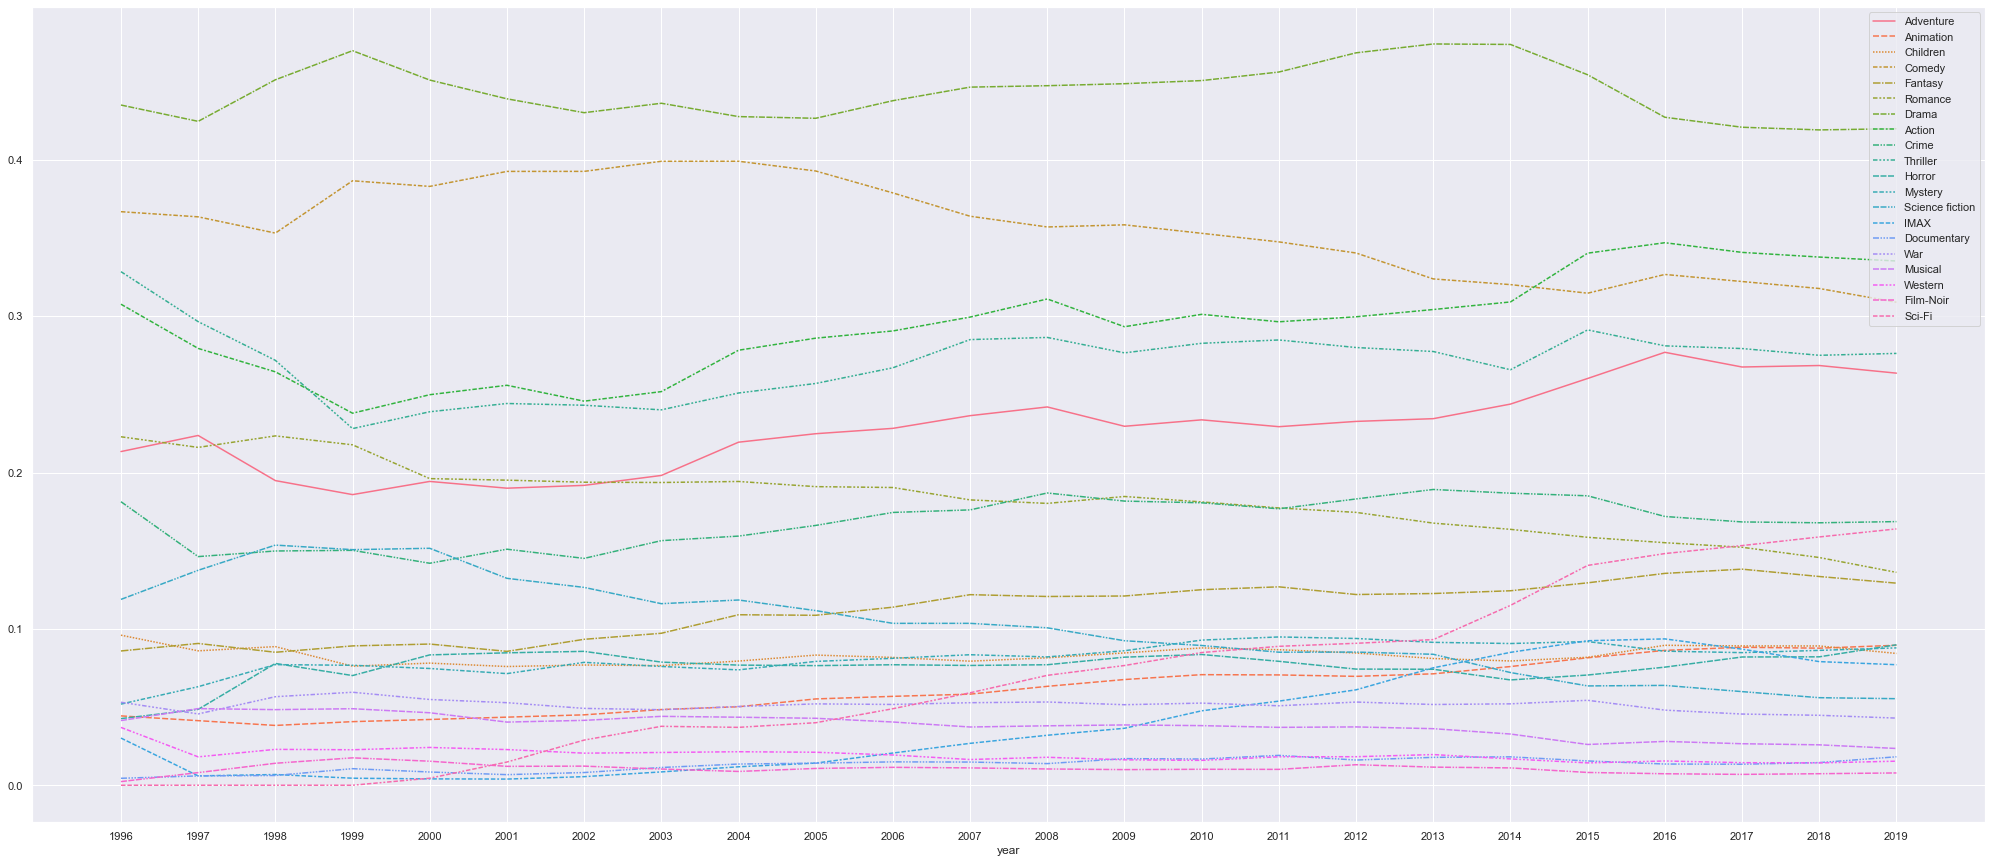

In [ ]:
sns.set(rc = {'figure.figsize':(35,15)})
sns.lineplot(data=mediaMR)

Aspectos que podrían afectar a los dos análisis:
- Hay años con bastante menos valoraciones lo que podría afectar a las consultas
- Del año 2021 solo hay datos hasta noviembre.
- Aunque creo que haya sido buenas decisiones las que se han tomado para la parte de preprocesamiento, a lo mejor habría datos que resultarían útiles y afectarían en algo si se tratasen de otra manera o teniendo un mejor contexto.